In [1]:
import os
import torchaudio
import torch
import matplotlib.pyplot as plt
from torch.nn import Module, Linear, Sigmoid, LSTM, BCELoss, MSELoss
from torch.optim import Adam
import torch.nn.functional as F
from pytorch_model_summary import summary
from tqdm import tqdm
import numpy as np
import random
import speechbrain as sb
from speechbrain.nnet.losses import get_si_snr_with_pitwrapper

## Load Data

In [2]:
REFERENCE_CHANNEL = 0
SAME_LENGTH = True
THR_S = 0.5 # Threshold for speech IRM
THR_N = 0.5
N_PATH = "/project/data_asr/CHiME5/data/librenoise/free-sound/"#"/Users/danilfedorovsky/Documents/10 Collection/00 Studium/00 Letztes Semester/Masterarbeit/Data/noise/free-sound/"
S_PATH = "/project/data_asr/CHiME5/data/librenoise/dev/dev-clean/"#"/Users/danilfedorovsky/Documents/10 Collection/00 Studium/00 Letztes Semester/Masterarbeit/Data/LibriSpeech/dev-clean/"
MODEL_SAVE_PATH = "/project/data_asr/CHiME5/data/librenoise/models/"
def load_noise(N_PATH=N_PATH):
    noise = []
    for file in  os.listdir(N_PATH):
        if file[-4:] == ".wav":
            sound, _ = torchaudio.load(N_PATH+file)
            noise.append(sound)
    return noise


def load_speech(S_PATH=S_PATH):
    speech = []
    for folder in  os.listdir(S_PATH):
        if os.path.isdir(S_PATH+folder):
            for subfolder in os.listdir(S_PATH+folder):
                if os.path.isdir(S_PATH+folder+"/"+subfolder):
                    for file in os.listdir(S_PATH+folder+"/"+subfolder):
                        if file[-5:] == ".flac":
                            sound, _ = torchaudio.load(S_PATH+folder+"/"+subfolder+"/"+file)
                            if SAME_LENGTH:
                                try:
                                    sound = torch.narrow(sound,1,0,50000)# Narrow to 50000
                                except Exception:
                                    # add zeros to make sound 50000 long
                                    len_sound = sound.shape[1]
                                    add_zeros = 50000 - len_sound
                                    add_zeros = torch.zeros(add_zeros).reshape(1,-1)
                                    sound = torch.concat([sound,add_zeros],dim=1)
                            speech.append(sound)
    return speech

def add_noise_to_speech(speech, noise, ratio1: float, ratio2: float):
    X = []
    X2 = []
    newNoise = []
    for sample in speech:
        len_speech = sample.shape[1]
        sample_noise = random.choice(noise)
        while sample_noise.shape[1]<len_speech:
            sample_noise = torch.concat([sample_noise,sample_noise],dim=1)# Repeat to ensure noise is longer than speech
        sample_noise = torch.narrow(sample_noise,1,0,len_speech)# Shorten noise to same length as speech
        x = torch.add(sample,sample_noise*ratio1)# Same Ratio 1:1
        x2 = torch.add(sample,sample_noise*ratio2)# Same Ratio 1:1
        sample_noise = torch.narrow(sample_noise,1,0,len_speech)
        X.append(x)
        X2.append(x)
        newNoise.append(sample_noise)
    return X, X2, newNoise    

def prep_xij(trainX,i,j):
    real_part = trainX[i][j].real
    imag_part = trainX[i][j].imag
    return torch.cat((real_part.unsqueeze(2),imag_part.unsqueeze(2)),2)

speech = load_speech()
noise = load_noise()
noise = noise[:5]
X, X2, noise = add_noise_to_speech(speech, noise, 0.1, 0.3)

print(len(speech), speech[0].shape)
print(len(noise), noise[0].shape)
print(len(X), X[0].shape)

2703 torch.Size([1, 50000])
2703 torch.Size([1, 50000])
2703 torch.Size([1, 50000])


In [3]:
# STFT
N_FFT = 1024
N_HOP = 256

stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)

stfts_mix = []
for n in range(0,len(X)):
    x_new = torch.concat([stft(X[n]),stft(X2[n])],dim=0)
    stfts_mix.append(x_new)

    
stfts_clean = []
for y in speech:
    y_new = stft(y)
    y_new = y_new.reshape(513,-1)
    stfts_clean.append(y_new)

stfts_noise = []
i = 0
for n in noise:
    try:
        n_new = stft(n)
        stfts_noise.append(n_new.reshape(513,-1))
    except Exception: #sometimes noises are very short, e.g. noise[697]
        continue

print(stfts_clean[0].shape)
print(stfts_mix[0][0].shape)
print(stfts_noise[0].shape)

torch.Size([513, 196])
torch.Size([513, 196])
torch.Size([513, 196])


In [4]:
def get_irms(stft_clean, stft_noise):
    mag_clean = stft_clean.abs() ** 2
    mag_noise = stft_noise.abs() ** 2
    irm_speech = mag_clean / (mag_clean + mag_noise)
    irm_noise = mag_noise / (mag_clean + mag_noise)
    return irm_speech[REFERENCE_CHANNEL], irm_noise[REFERENCE_CHANNEL]

Y = []
for n in range(0,len(noise)):
    irm_speech, irm_noise = get_irms(stfts_clean[n].unsqueeze(0), stfts_noise[n].unsqueeze(0))
    irm_speech = (irm_speech>THR_S).float()
    irm_noise = (irm_noise>THR_N).float()
    Y.append(torch.cat((irm_speech.unsqueeze(0),irm_noise.unsqueeze(0)),0))

X_h = []
stfts_mix_s = torch.stack(stfts_mix)

for i in range(0, len(stfts_mix)):
    for j in range (0,1):
        X_h.append(torch.cat((stfts_mix_s[i][j].real.unsqueeze(0),stfts_mix_s[i][j].imag.unsqueeze(0)),0))

speech_s = torch.stack(speech)
noise_s = torch.stack(noise)
Y = torch.stack(Y)
X = torch.stack(X_h)
Y = speech_s # NEW

# MaskNet + Training

In [5]:
# MASK NET
HIDDEN_SIZE=1024 # 1024 (128 is too litte, just learns all 0 or 1)
SAMPLE_RATE = 16000
INPUT_CHANNEL = 2 # Always two -> Real and Imaginary part 

class MaskNet(Module):
    def __init__(self,noise=False):
        super(MaskNet, self).__init__()
        # First subnet for speech prediction
        self.noise = noise
        self.lstm = LSTM(input_size=INPUT_CHANNEL, hidden_size=HIDDEN_SIZE, num_layers=2, bidirectional=True)
        self.fc = Linear(in_features=HIDDEN_SIZE*2 ,out_features=1)
        self.sigmoid = Sigmoid()

    def forward(self,x):
        # Speech prediction
        x = x.reshape(513,-1,2)
        self.lstm.flatten_parameters()
        y, (h_n, c_n) = self.lstm(x)
        y = self.fc(y)
        speech_pred = self.sigmoid(y)
        return speech_pred#, noise_pred

print(summary(MaskNet(),torch.zeros((2, 196, 513))))

--------------------------------------------------------------------------------------------------------
      Layer (type)                                         Output Shape         Param #     Tr. Param #
            LSTM-1     [513, 196, 2048], [4, 196, 1024], [4, 196, 1024]      33,603,584      33,603,584
          Linear-2                                        [513, 196, 1]           2,049           2,049
         Sigmoid-3                                        [513, 196, 1]               0               0
Total params: 33,605,633
Trainable params: 33,605,633
Non-trainable params: 0
--------------------------------------------------------------------------------------------------------


In [8]:
EPOCHS = 10
BATCH_SIZE = 1
REFERENCE_CHANNEL = 0
INIT_LR = 0.01

CUDA = True # if torch.cuda.is_available()
device =  torch.device("cuda:2") if torch.cuda.is_available() else torch.device('cpu')
print("Mounted on:", device)

lossBCE = MSELoss()
#lossSiSNR = get_si_snr_with_pitwrapper([1,],[])
model = MaskNet().to(device)
model= torch.nn.DataParallel(model,device_ids=[2,3])
opt = Adam(model.parameters(), lr=INIT_LR)

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

def check_accuracy_training(speech_pred, y_s):
    return float(torch.add(speech_pred,-y_s))

def check_accuracy_validation(model):
    example_nr = int(np.random.random()*(len(speech)-len(trainX))+len(trainX))
    model.eval()
    pred=maskToWave(model(X[example_nr]).reshape(513,-1),example_nr)
    val_loss = lossBCE(pred,Y[example_nr])
    model.train()
    return val_loss

istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP).to(device)

def maskToWave(speech_pred,i):
        mix = stfts_mix[i].to(device)
        noise_pred = torch.ones([513,mix.shape[2]]).to(device)-speech_pred
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix, speech_pred)
        psd_noise = psd_transform(mix, noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix, psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
        waveform_souden = istft(stft_souden, length=50000)#X[i].shape[-1])
        return waveform_souden.unsqueeze(0)

print("[INFO] training the network...")

for epoch in range(0, EPOCHS):
    print("Epoch:",str(epoch+1)+"/"+str(EPOCHS))
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    X = X.to(device)
    Y = Y.to(device)
    trainX = X[:2000]
    trainY = Y
    for i in tqdm(range(0,len(trainX))): # Iterate over Training Examples
        (x, y) = (trainX[i],trainY[i][0].unsqueeze(0))
        speech_pred=maskToWave(model(x).reshape(513,-1),i)
        loss = lossBCE(speech_pred,y)
        # zero out the gradients, perform the backpropagation step, and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        #H["train_acc"].append(check_accuracy_training(speech_pred,y))
        H["train_loss"].append(float(loss))
        if i % 10 == 0:
            val_loss = check_accuracy_validation(model)
        #    H["val_acc"].append(val_acc)
            H["val_loss"].append(float(val_loss))
        if i % 100 == 0:
            if i == 0:
                continue
            #print("Average Training Accuracy at Iteration",str(i),":",np.mean(np.array(H["train_acc"])))
            print("Total Training Loss at Iteration",str(i),":",np.sum(np.array(H["train_loss"])))
            # print("Average Validation Accuracy at Iteration",str(i),":",np.mean(np.array(H["val_acc"])))
            print("Total Validation Loss at Iteration",str(i),":",np.sum(np.array(H["val_loss"])))
            # Reset H
            H = {
                "train_loss":[],
                "val_acc":[]
            }
    # Save
    PATH = "./models/modelLibre"
    torch.save(model.state_dict(), PATH + "epoch"+ str(epoch+1) + ".pt")

PATH = "./models/modelLibre"
torch.save(model.state_dict(), PATH + "final" + ".pt")

Mounted on: cuda:2
[INFO] training the network...
Epoch: 1/10


  0%|          | 0/2000 [00:02<?, ?it/s]


KeyboardInterrupt: 

## Load Model & Evaluate

In [9]:
MODEL_NAME = "modelLibreepoch9.pt"
device =  torch.device("cuda:2") if torch.cuda.is_available() else torch.device('cpu')
model = MaskNet().to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH+MODEL_NAME),strict=False)
model.eval()

MaskNet(
  (lstm): LSTM(2, 1024, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [43]:
torch.cuda.empty_cache()

In [15]:
speech_pred = model(X[0])
speech_pred.reshape(1,-1,513).shape

torch.Size([1, 196, 513])

In [11]:
X[0]

tensor([[[-1.2793e-01, -9.9042e-02, -5.1017e-03,  ...,  9.7824e-03,
          -1.3881e-01, -4.7550e-01],
         [ 4.3836e-02,  8.4953e-02, -1.8586e-02,  ..., -2.3174e-02,
          -4.0177e-02,  4.0499e-01],
         [ 4.9334e-02, -6.8202e-02,  3.4634e-02,  ...,  3.5956e-02,
           6.2465e-02, -2.4558e-01],
         ...,
         [-6.7703e-03,  2.6331e-03,  6.8505e-04,  ..., -3.8460e-03,
          -3.0316e-04,  2.5928e-03],
         [ 8.4928e-03,  3.3914e-03,  3.7532e-03,  ...,  2.7053e-03,
          -3.7027e-03, -8.7752e-03],
         [-1.2008e-02, -9.7158e-03, -7.3389e-03,  ...,  2.5510e-03,
           7.1581e-03,  1.3490e-02]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 9.0316e-09,  2.7991e-02,  6.3023e-02,  ..., -1.1055e-03,
          -1.3249e-01, -2.0351e-01],
         [-7.9830e-10, -9.6717e-03, -1.4855e-02,  ...,  1.0660e-02,
          -9.5519e-02,  3.4566e-01],
         ...,
         [-8.0012e-10, -1

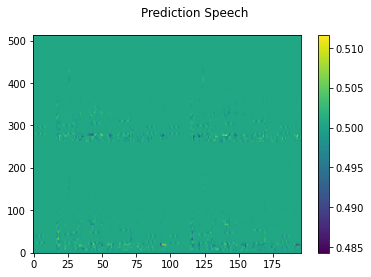

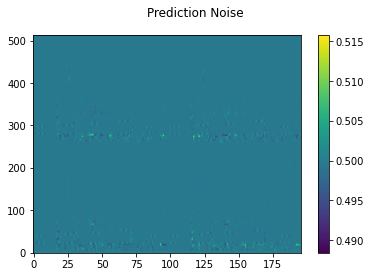

TypeError: Invalid shape (50000,) for image data

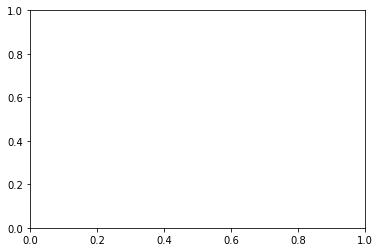

In [10]:
def evaluate_example(e_nr):
    model.eval()
    #speech_pred = (model(X[e_nr]).reshape(513,-1)>0.2).float()
    speech_pred=maskToWave(model(X[e_nr].to(device)).reshape(513,-1),e_nr)
    speech_pred = model(X[e_nr].to(device)).reshape(513,-1)
    noise_pred = torch.ones([513,stfts_mix[e_nr].shape[2]]).to(device)-speech_pred
    plot_mask(speech_pred, title="Prediction Speech")
    plot_mask(noise_pred, title="Prediction Noise")
    plot_mask(trainY[e_nr][0], title="Reference Speech")
    plot_mask(trainY[e_nr][1], title="Reference Noise")

def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.cpu().detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

# def maskToWave(speech_pred,noise_pred,mix,i):
#         model.eval()
#         psd_transform = torchaudio.transforms.PSD()
#         psd_speech = psd_transform(mix[i], speech_pred)
#         psd_noise = psd_transform(mix[i], noise_pred)
#         mvdr_transform = torchaudio.transforms.SoudenMVDR()
#         stft_souden = mvdr_transform(mix[i], psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
#         waveform_souden = istft(stft_souden, length=len(X[i][0]))#X[i].shape[-1])
#         return waveform_souden.reshape(-1)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP).to(device)

def maskToWave(speech_pred,i):
        mix = stfts_mix[i].to(device)
        noise_pred = torch.ones([513,mix.shape[2]]).to(device)-speech_pred
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix, speech_pred)
        psd_noise = psd_transform(mix, noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix, psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
        waveform_souden = istft(stft_souden, length=50000)#X[i].shape[-1])
        return waveform_souden.unsqueeze(0)

evaluate_example(0)

In [14]:
speech_pred = trainY[0][0]
noise_pred = trainY[0][1]

def evaluateSiSNR(wave, i):
    def si_snr(estimate, reference, epsilon=1e-8):
        estimate = estimate - estimate.mean()
        reference = reference - reference.mean()
        reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
        mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
        scale = mix_pow / (reference_pow + epsilon)

        reference = scale * reference
        error = estimate - reference

        reference_pow = reference.pow(2)
        error_pow = error.pow(2)

        reference_pow = reference_pow.mean(axis=1)
        error_pow = error_pow.mean(axis=1)

        si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
        return si_snr.item()
    score = si_snr(wave, speech[i])
    print(f"Si-SNR score: {score}") 
    return score

def maskToWave(speech_pred,noise_pred,mix,i):
        model.eval()
        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(mix[i], speech_pred)
        psd_noise = psd_transform(mix[i], noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(mix[i], psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
        waveform_souden = istft(stft_souden, length=len(X[i][0]))#X[i].shape[-1])
        return waveform_souden.reshape(-1)

def save_sample(i,wave,sample_rate=SAMPLE_RATE):
    model.eval()
    wave = wave
    torchaudio.save("sampleall_output.wav",wave.reshape(1,-1),sample_rate)
    torchaudio.save("sampleall_reference.wav", speech[i].reshape(1,-1),sample_rate)
    torchaudio.save("sampleall_input.wav", X[i].reshape(1,-1),sample_rate)


sample_nr = 51
speech_pred = (model(prep_xij(stfts_mix,sample_nr,0))>0.15).float()
noise_pred = torch.ones([513,speech_pred.shape[1]])-speech_pred
wave = maskToWave(speech_pred,noise_pred,stfts_mix,sample_nr)
save_sample(sample_nr, wave=wave)
score = evaluateSiSNR(wave,sample_nr)#Should be ~16

Si-SNR score: -0.38113975524902344
